<a href="https://colab.research.google.com/github/siddhantdubey/GenderedMovieDialogue/blob/master/GenderClassifierCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Folders/Work/Research/CornellMovie/data/"

Mounted at /content/gdrive


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.parsing.preprocessing import remove_stopwords
from gensim.utils import simple_preprocess
from gensim.parsing.porter import PorterStemmer
from gensim.models import Word2Vec


In [ ]:
X_train = []
Y_train = []
X_test = []
Y_test = []

In [ ]:
with open(root_dir + 'training_set.txt', encoding="charmap") as training:
  for line in training:
    line = line.strip()
    line_num, chr_id, movie_id, chr_name, chr_gender, line_text, credit = line.split("+++$+++")
    if(chr_gender.strip().lower() == "m"):
      Y_train.append(0)
      X_train.append(line_text.strip())
    elif(chr_gender.strip().lower() == "f"):
      Y_train.append(1)
      X_train.append(line_text.strip())

with open(root_dir + 'test_set.txt', encoding="charmap") as test:
  for line in test:
    line = line.strip()
    line_num, chr_id, movie_id, chr_name, chr_gender, line_text, credit = line.split("+++$+++")
    if(chr_gender.strip().lower() == "m"):
      Y_test.append(0)
      X_test.append(line_text.strip())

    elif(chr_gender.strip().lower() == "f"):
      Y_test.append(1)
      X_test.append(line_text.strip())

In [ ]:
X = X_train + X_test 
Y = Y_train + Y_test 

In [ ]:
indices = []
for i in range(len(X)):
  if(len(X[i]) > 0):
    answer = True 
  else:
    indices.append(i)

for index in sorted(indices, reverse=True):
    del X[index]
    del Y[index]

In [ ]:
data_df = pd.DataFrame()

In [ ]:
data_df['text'] = X
data_df['gender'] = Y
print(data_df.head(10))

                                                text  gender
0                                       They do not!       1
1                                        They do to!       0
2                                         I hope so.       1
3                                          She okay?       0
4                                          Let's go.       1
5                                                Wow       0
6     Okay -- you're gonna need to learn how to lie.       1
7                                                 No       0
8  I'm kidding.  You know how sometimes you just ...       1
9                   Like my fear of wearing pastels?       1


In [ ]:
def get_top_data(top_n = 30000):
  top_data_df_male = data_df[data_df['gender'] == 0].head(top_n)
  top_data_df_female = data_df[data_df['gender'] == 1].head(top_n)
  data_df_small = pd.concat([top_data_df_male, top_data_df_female])
  return data_df_small

In [ ]:
top_data_df_small = get_top_data(top_n=31000)

In [ ]:
print(top_data_df_small['gender'].value_counts())
print(top_data_df_small.head(10))

1    31000
0    31000
Name: gender, dtype: int64
                                                 text  gender
1                                         They do to!       0
3                                           She okay?       0
5                                                 Wow       0
7                                                  No       0
10                                    The "real you".       0
12  I figured you'd get to the good stuff eventually.       0
13  Thank God!  If I had to hear one more story ab...       0
15                                         What crap?       0
17                                              No...       0
19                      You always been this selfish?       0


In [ ]:
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']]
print(top_data_df_small['tokenized_text'].head(10))


1                                        [they, do, to]
3                                           [she, okay]
5                                                 [wow]
7                                                  [no]
10                                     [the, real, you]
12    [figured, you, get, to, the, good, stuff, even...
13    [thank, god, if, had, to, hear, one, more, sto...
15                                         [what, crap]
17                                                 [no]
19                   [you, always, been, this, selfish]
Name: tokenized_text, dtype: object


In [ ]:
porter_stemmer = PorterStemmer()

In [ ]:
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text']]
top_data_df_small['stemmed_tokens'].head(10)

1                                        [thei, do, to]
3                                           [she, okai]
5                                                 [wow]
7                                                  [no]
10                                     [the, real, you]
12      [figur, you, get, to, the, good, stuff, eventu]
13    [thank, god, if, had, to, hear, on, more, stor...
15                                         [what, crap]
17                                                 [no]
19                     [you, alwai, been, thi, selfish]
Name: stemmed_tokens, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
def split_train_test(top_data_df_small, test_size=0.2, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['text', 'stemmed_tokens']], 
                                                        top_data_df_small['gender'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train genders")
    print(Y_train.value_counts())
    print("Value counts for Test genders")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train genders
0    24842
1    24758
Name: gender, dtype: int64
Value counts for Test genders
1    6242
0    6158
Name: gender, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index  ...                                     stemmed_tokens
0  10055  ...  [perfectli, certain, becaus, shall, make, him,...
1  36234  ...  [am, small, player, but, if, by, help, you, ca...
2  38206  ...         [love, anim, ouch, must, love, anim, rose]
3  25549  ...                 [wick, thei, got, your, crew, too]
4  47537  ...                                            [peter]

[5 rows x 3 columns]


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:
size = 500
window = 3
min_count = 1
workers = 3
sg = 1
OUTPUT_FOLDER = root_dir + 'cnnOutputs/'
# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = OUTPUT_FOLDER + 'models/' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, size = size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(top_data_df_small, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

62000


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.vocab['pad'].index
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.vocab:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.vocab[word].index
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [ ]:
def make_target(label):
    if label == 1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    

In [ ]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 2
import gensim

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + 'models/' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.vocab['pad'].index)
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [ ]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [ ]:
import time
NUM_CLASSES = 2
VOCAB_SIZE = len(w2vmodel.wv.vocab)

cnn_model = CnnTextClassifier(vocab_size=VOCAB_SIZE, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
criterion=nn.BCEWithLogitsLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 30

# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER +  'plots/' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w+')
f.write('iter, loss')
f.write('\n')
losses = []
accs = []
cnn_model.train()
total_time = time.time()
for epoch in range(num_epochs):
    print("Epoch " + str(epoch + 1))
    train_loss = 0
    epoch_acc = 0
    t= time.time()
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)
     
        # Get the target label
        target = make_target(Y_train['gender'][index])
   
        acc = binary_accuracy(probs, target)
        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()
        epoch_acc += acc.item()
        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran : "+ str(epoch+1))
    losses.append(train_loss)
    accs.append(epoch_acc)
    print("Loss: " + str(train_loss/len(X_train)) + '\n')
    print("Acc: " + str(epoch_acc/len(X_train)) + '\n')
    # print(str(train_loss / len(X_train)))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0
    print("Time for Epoch: " + f'time:{time.time()-t:.3f}')
torch.save(cnn_model, OUTPUT_FOLDER + 'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])
print(f"Total training time:{time.time()-total_time:.3f}")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Epoch 1
Epoch ran : 1
Loss: 0.6910126071219002

Acc: 1.0016935483870968

Time for Epoch: time:347.548
Epoch 2
Epoch ran : 2
Loss: 0.689455940818354

Acc: 1.0016935483870968

Time for Epoch: time:341.777
Epoch 3
Epoch ran : 3
Loss: 0.6879701623044187

Acc: 1.0016935483870968

Time for Epoch: time:346.730
Epoch 4
Epoch ran : 4
Loss: 0.6865106315586356

Acc: 1.0016935483870968

Time for Epoch: time:345.374
Epoch 5
Epoch ran : 5
Loss: 0.6865880737225375

Acc: 1.0016935483870968

Time for Epoch: time:343.950
Epoch 6
Epoch ran : 6
Loss: 0.6855349385401895

Acc: 1.0016935483870968

Time for Epoch: time:345.883
Epoch 7
Epoch ran : 7
Loss: 0.6844313704006133

Acc: 1.0016935483870968

Time for Epoch: time:346.477
Epoch 8
Epoch ran : 8
Loss: 0.6830093969596971

Acc: 1.0016935483870968

Time for Epoch: time:348.486
Epoch 9
Epoch ran : 9
Loss: 0.6825892695375989

Acc: 1.0016935483870968

Time for Epoch: time:346.254
Epoch 10
Epoch ran : 10
Loss: 0.6824851126608349

Acc: 1.0016935483870968

Time for

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type CnnTextClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Index(['iter', ' loss'], dtype='object')
              precision    recall  f1-score   support

           0       0.54      0.75      0.63      6242
           1       0.57      0.34      0.43      6158

    accuracy                           0.55     12400
   macro avg       0.56      0.55      0.53     12400
weighted avg       0.55      0.55      0.53     12400

Index(['iter', ' loss'], dtype='object')


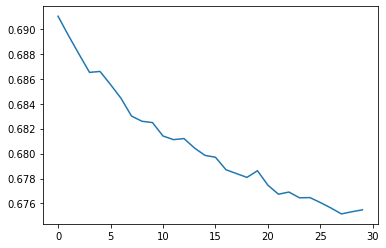

In [ ]:
from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + 'plots/' 'cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
test_accs = []
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['gender'][index]).cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = OUTPUT_FOLDER +  'plots/' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER +'plots/' + "loss_plt_500_padding_30_epochs.pdf")